## Inicialización

In [3]:
# Cargamos las librerías que necesitamos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargamos las librerías de keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [4]:
# Leemos los datos de labels
pd_labels = pd.read_csv("/datasets/faces/labels.csv")

# Ahora las imágenes con un iterador
train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=pd_labels,
    directory="/datasets/faces/final_files/",
    x_col="file_name",
    y_col="real_age",
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    seed=12345
)

Found 7591 validated image filenames.


## EDA
Realicemos nuestro análisis exploratorio, empecemos viendo un describe de nuestro dataset.

In [5]:
pd_labels.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Tenemos un rango de edad de 1 a 100 años, y 7591 entradas, con 50% de nuestros datos entre 20 y 41 años. Veamos los cinco valores más bajos y los cinco más altos (para comprobar que no son errores y darnos una idea del tipo de valores que tenemos).

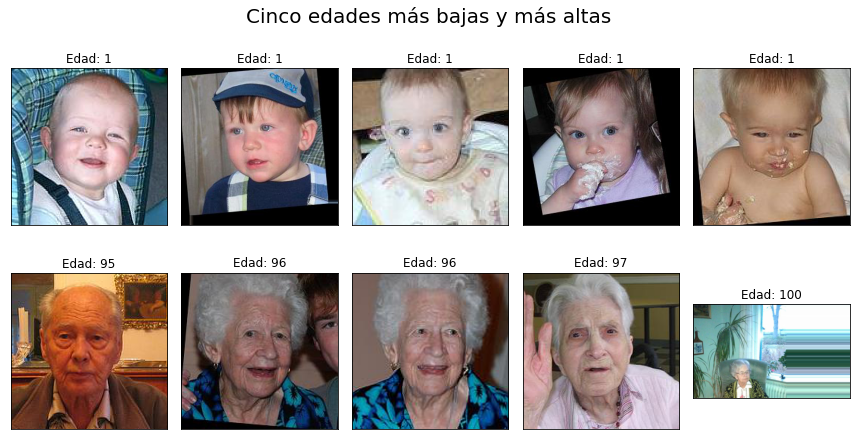

In [6]:
# Definamos los valores más bajos, altos
pd_lowest = pd_labels.sort_values("real_age").head()
pd_highest = pd_labels.sort_values("real_age").tail()

# Juntamos
pd_head_tail = pd.concat([pd_lowest, pd_highest]).reset_index(drop=True)

# Ploteamos
fig = plt.figure(figsize=(12,7))
for index, row in pd_head_tail.iterrows():
    fig.add_subplot(2,5, index+1)
    plt.imshow(
        plt.imread("/datasets/faces/final_files/"+row.file_name)
    )
    plt.title(f"Edad: {row.real_age}")
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()

plt.suptitle("Cinco edades más bajas y más altas", size=20)
plt.show()

Los valores se ven apropiados, incluso parece que ya tenemos algunas imágenes rotadas y aumentadas en nuestro dataset. Ahora mostremos las fotografías para un batch de nuestro iterador.

<div class="alert alert-block alert-success">
    <b>Comentarios del Revisor</b> <a class="tocSkip"></a><br>
    Correcto. Continúa con el buen trabajo! </div>

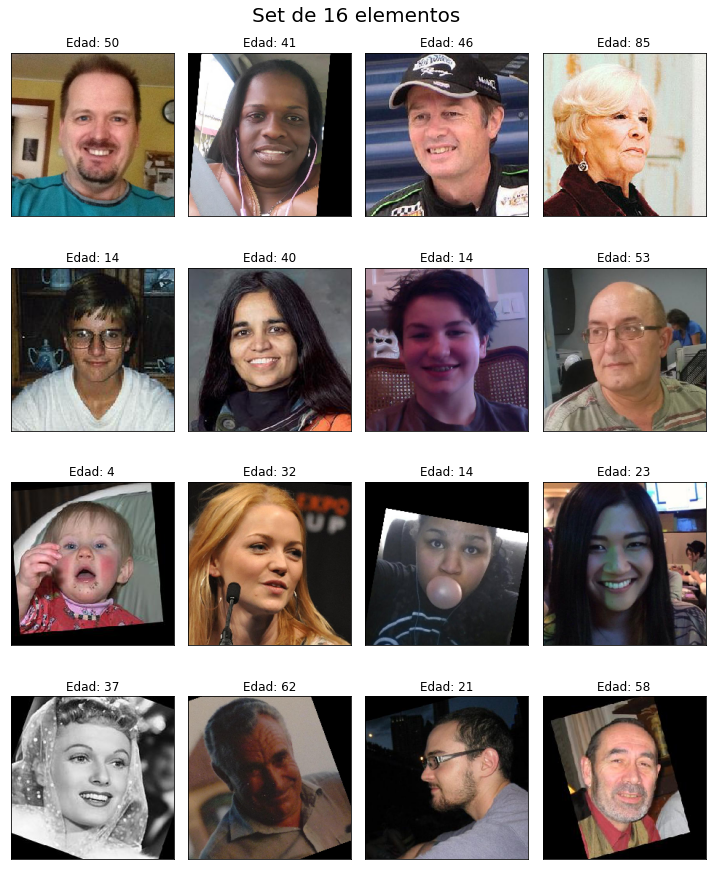

In [7]:
features, target = next(train_datagen_flow)

# muestra 16 imágenes
fig = plt.figure(figsize=(10,13))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Edad: {target[i]}")
    plt.tight_layout()
    
plt.suptitle("Set de 16 elementos", size=20)
plt.show()

Todo se ve en órden, ahora mostremos como se distibuyen las edades en nuestro conjunto de entrenamiento.

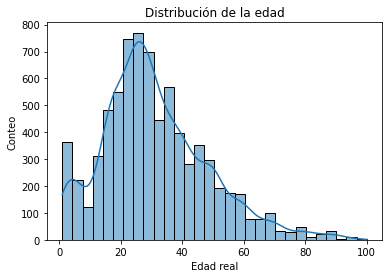

In [9]:
#Ploteamos
sns.histplot(
    data=pd_labels,
    x="real_age",
    bins=30, kde=True
)

plt.title("Distribución de la edad")
plt.xlabel("Edad real")
plt.ylabel("Conteo")
plt.show()

Parece que nuestra distribución esta sesgada claramente hacia los valores más bajos: las edades no suelen ser muy altas en la mayoría de la población. Esto podría dar problemas para identificar edades después de los 60 ya que hay muchos menos entradas para estos grupos de edad.

### Conclusiones

Tenemos una distribución bastante amplia de valores entre 1 a 100 años: las imágenes estan concentradas entre 20 y 60 años de edad, siendo 7591 elementos en total. Nuestro conjunto de datos tiene imágenes ya ampliadas y procesadas para ser usadas, sin embargo puede que no todas las edades se puedan entrenar correctamente debido a que no hay demasiadas en edades cercanos (por ejemplo, edades mayores a 60 años o menores de 20): tal vez podríamos sortear esto si intentamos ampliar nuestro dataset al correrlo. Por otro lado, nótese que la distribución de hombres/mujeres se ve bastante balanceada cuando mostramos datos al azar.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [ ]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    # Leemos los datos de labels
    pd_labels = pd.read_csv(path+"labels.csv")

    # Ahora las imágenes con un iterador
    train_datagen = ImageDataGenerator(
        rescale=1./255, horizontal_flip=True, vertical_flip=True, validation_split=0.25
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd_labels,
        directory=(path+"final_files/"),
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=16,
        class_mode="raw",
        subset="training",
        seed=12345
    )

    return train_datagen_flow

In [ ]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    # Leemos los datos de labels
    pd_labels = pd.read_csv(path+"labels.csv")

    # Ahora las imágenes con un iterador
    test_datagen = ImageDataGenerator(
        rescale=1./255, validation_split=0.25
    )

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd_labels,
        directory=(path+"final_files/"),
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=16,
        class_mode="raw",
        subset="validation",
        seed=12345
    )

    return test_datagen_flow

In [ ]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    backbone = ResNet50(
        input_shape=input_shape,
        #classes=1000,
        include_top=False,
        weights="imagenet"
    )
    
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(units=1, activation="relu")
    ])

    model.compile(
        loss="mse",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["mae"]
    )
    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí (se han removido los mensajes de advertencia).

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
12042240/94765736 [==>...........................] - ETA: 0s
24772608/94765736 [======>.......................] - ETA: 0s
37478400/94765736 [==========>...................] - ETA: 0s
50405376/94765736 [==============>...............] - ETA: 0s
63094784/94765736 [==================>...........] - ETA: 0s
76201984/94765736 [=======================>......] - ETA: 0s
89194496/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 0s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 47s - loss: 225.8893 - mae: 11.1339 - val_loss: 447.2182 - val_mae: 15.9812
Epoch 2/5
356/356 - 38s - loss: 112.4172 - mae: 8.0517 - val_loss: 145.5489 - val_mae: 9.2801
Epoch 3/5
356/356 - 38s - loss: 88.6288 - mae: 7.1732 - val_loss: 94.9328 - val_mae: 7.5046
Epoch 4/5
356/356 - 38s - loss: 71.9453 - mae: 6.4851 - val_loss: 107.9371 - val_mae: 8.0045
Epoch 5/5
356/356 - 38s - loss: 61.9482 - mae: 6.0002 - val_loss: 91.8302 - val_mae: 7.2226

119/119 - 9s - loss: 91.8302 - mae: 7.2226
Test MAE: 7.2226

## Conclusiones

Hemos partido de hacer un vistazo rápido a nuestra información en un análisis exploratorio de datos: tenemos casi ocho mil entradas de imágenes de caras, con una distribución mayoritaria de personas jóvenes. Entrenamos un modelo con un backbone de ResNet50 y le agregamos dos capas más: una de promedio y otra red neuronal con activación ReLU. Los resultados de nuestro entrenamiento son prometedores, obteniendo un error absoluto medio de 7.226. Sin embargo es útil ver la siguiente gráfica que muestra los valores de la función de pérdida (el error cuádratico medio).

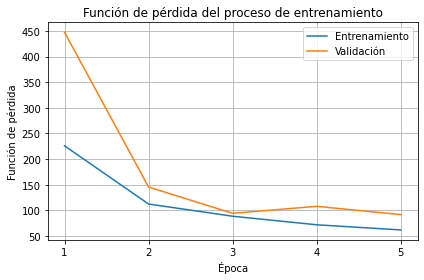

In [53]:
# Definimos valores
x_range = [1,2,3,4,5]
loss_train = [225.8893, 112.4172, 88.6288, 71.9453, 61.9482]
loss_val = [447.2182, 145.5489, 94.3238, 107.9371, 91.8302]

pd_loss = pd.DataFrame(
    zip(x_range, loss_train, loss_val), columns=["epoch", "train", "val"]
)

# Ploteamos
sns.lineplot(
    data=pd_loss, x="epoch", y="train"
)
sns.lineplot(
    data=pd_loss, x="epoch", y="val"
)

# Embellecemos
plt.legend(["Entrenamiento", "Validación"])

plt.title("Función de pérdida del proceso de entrenamiento")
plt.xlabel("Época")
plt.ylabel("Función de pérdida")
plt.xticks([1,2,3,4,5])

plt.grid()
plt.tight_layout()
plt.show()